In [1]:
from src.dataset import Dataset
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

# Einlesen Daten und plotten

In [2]:
traindataset= Dataset(r"raw_data\ZueriCrop\ZueriCrop.hdf5", 0., 'train', False, 1, "labels.csv", num_channel=4, apply_cloud_masking=False,small_train_set_mode=False)
traindataloader = torch.utils.data.DataLoader(traindataset, batch_size=1, shuffle=True, num_workers=0)

5fold:  1   Mode:  train
Dataset size:  27977
Valid dataset size:  22382
Sequence length:  71
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


In [3]:
for iteration, data in enumerate(next(iter(traindataloader))):
    data_i = data
    print(data[0].shape)
    print(data[0])

torch.Size([71, 4, 24, 24])
tensor([[[[3.1840e-01, 3.2000e-01, 3.0820e-01,  ..., 2.4220e-01,
           2.4740e-01, 2.5300e-01],
          [3.2840e-01, 3.2640e-01, 3.1340e-01,  ..., 2.5320e-01,
           2.7240e-01, 2.7360e-01],
          [3.2540e-01, 3.2540e-01, 3.1340e-01,  ..., 2.7460e-01,
           2.8880e-01, 2.8460e-01],
          ...,
          [3.2640e-01, 3.2920e-01, 3.0420e-01,  ..., 3.4640e-01,
           3.5000e-01, 3.5380e-01],
          [3.2640e-01, 3.1160e-01, 2.8540e-01,  ..., 3.4180e-01,
           3.4480e-01, 3.5500e-01],
          [3.2320e-01, 3.0500e-01, 2.8200e-01,  ..., 3.4320e-01,
           3.4880e-01, 3.5580e-01]],

         [[2.5900e-01, 2.6480e-01, 2.5180e-01,  ..., 1.5420e-01,
           1.7280e-01, 1.8420e-01],
          [2.6640e-01, 2.6580e-01, 2.5880e-01,  ..., 1.7640e-01,
           1.9620e-01, 2.0140e-01],
          [2.5440e-01, 2.5900e-01, 2.5520e-01,  ..., 2.0300e-01,
           2.2200e-01, 2.1540e-01],
          ...,
          [2.4700e-01, 2.4640e-

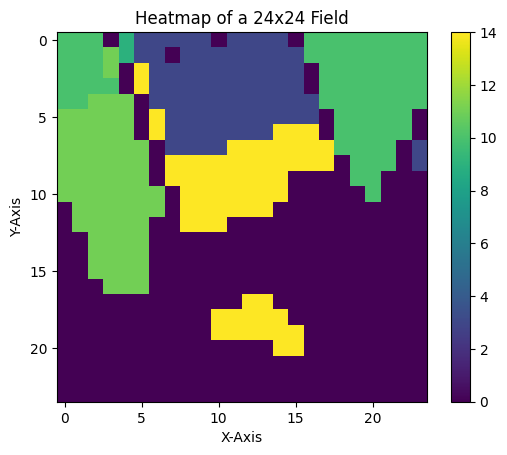

In [4]:
plt.imshow(data_i[0], cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a color bar on the right to indicate values
plt.title('Heatmap of a 24x24 Field')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.show()

# Label-Hierarchie
Die Ausgabe der oben gezeigten Heatmap gibt die Labels raus. Da uns nicht klar ist, welche Label-Nummer welchem LNF_Code entspricht, werden wir dies untersuchen und eine Übersetzungstabelle ausgeben.

Die folgenden code-Zeilen wurden dem ETH Repo entnommen

In [5]:
file=open("labels.csv", "r")
tier_1 = []
tier_2 = []
tier_3 = []
tier_4 = []
reader = csv.reader(file)
for line in reader:
    tier_1.append(line[-5])
    tier_2.append(line[-4])
    tier_3.append(line[-3])
    tier_4.append(line[-2])

tier_2[0] = '0_unknown'
tier_3[0] = '0_unknown'
tier_4[0] = '0_unknown'

label_list = []
for i in range(len(tier_2)):
    if tier_1[i] == 'Vegetation' and tier_4[i] != '':
        label_list.append(i)
        
    if tier_2[i] == '':
        tier_2[i] = '0_unknown'
    if tier_3[i] == '':
        tier_3[i] = '0_unknown'
    if tier_4[i] == '':
        tier_4[i] = '0_unknown'

tier_2_elements = list(set(tier_2))
tier_3_elements = list(set(tier_3))
tier_4_elements = list(set(tier_4))
tier_2_elements.sort()
tier_3_elements.sort()
tier_4_elements.sort()
    
tier_2_ = []
tier_3_ = []
tier_4_ = []
for i in range(len(tier_2)):
    tier_2_.append(tier_2_elements.index(tier_2[i]))
    tier_3_.append(tier_3_elements.index(tier_3[i]))
    tier_4_.append(tier_4_elements.index(tier_4[i]))  

label_list_local_1 = []
label_list_local_2 = []
label_list_glob = []
label_list_local_1_name = []
label_list_local_2_name = []
label_list_glob_name = []
for gt in label_list:
    label_list_local_1.append(tier_2_[int(gt)])
    label_list_local_2.append(tier_3_[int(gt)])
    label_list_glob.append(tier_4_[int(gt)])
    
    label_list_local_1_name.append(tier_2[int(gt)])
    label_list_local_2_name.append(tier_3[int(gt)])
    label_list_glob_name.append(tier_4[int(gt)])

n_classes = max(label_list_glob) + 1
n_classes_local_1 = max(label_list_local_1) + 1
n_classes_local_2 = max(label_list_local_2) + 1

l1_2_g = np.zeros(n_classes)
l2_2_g = np.zeros(n_classes)
l1_2_l2 = np.zeros(n_classes_local_2)

for i in range(1,n_classes):
    if i in label_list_glob:
        l1_2_g[i] = label_list_local_1[label_list_glob.index(i)]
        l2_2_g[i] = label_list_local_2[label_list_glob.index(i)]

for i in range(1,n_classes_local_2):
    if i in label_list_local_2:
        l1_2_l2[i] = label_list_local_1[label_list_local_2.index(i)]

In [6]:
df_raw = pd.read_csv('labels.csv')

structure_list = list(zip(l1_2_g, l2_2_g, tier_4_elements))
overview = pd.DataFrame(structure_list, columns = ['level1', 'level2', 'level3-name'])

overview.reset_index(inplace=True)
overview = overview.rename(columns = {'index':'level3'})

elem_gt = pd.DataFrame(tier_4_, columns=['level3'])
elem_gt.reset_index(inplace=True)
elem_gt = elem_gt.rename(columns = {'index':'GT'})

overview1 = pd.merge(overview, elem_gt, on='level3', how='left')
overview1 = pd.merge(overview1, df_raw, on='GT', how='left')

overview1 = overview1.drop(overview1.iloc[:,-7:], axis=1)

overview1 = overview1[['level1', 'level2', 'level3', 'level3-name', 'LNF_code', 'GT']]

lv3_to_lv2name = pd.DataFrame.from_dict(dict(zip(list(range(0,52)), np.array(tier_2_elements)[l1_2_g.astype(int)])),
                                        orient='index',
                                        columns=['level1-name']).reset_index(names="level3")
lv3_to_lv1name = pd.DataFrame.from_dict(dict(zip(list(range(0,52)), np.array(tier_3_elements)[l2_2_g.astype(int)])),
                                        orient='index',
                                        columns=['level2-name']).reset_index(names="level3")
overview1 = pd.merge(pd.merge(overview1,lv3_to_lv2name, on="level3"),lv3_to_lv1name,on= "level3")
overview1.to_csv('Level_hierarchy.csv')

In [7]:
overview1.head()

,level1,level2,level3,level3-name,LNF_code,GT,level1-name,level2-name
0,0.0,0.0,0,0_unknown,NaN,0,0_unknown,0_unknown
1,0.0,0.0,0,0_unknown,552.0,40,0_unknown,0_unknown
2,0.0,0.0,0,0_unknown,553.0,41,0_unknown,0_unknown
3,0.0,0.0,0,0_unknown,554.0,42,0_unknown,0_unknown
4,0.0,0.0,0,0_unknown,559.0,46,0_unknown,0_unknown


In [8]:
overview1.tail()

,level1,level2,level3,level3-name,LNF_code,GT,level1-name,level2-name
120,1.0,16.0,48,Wheat,507.0,6,Field crops,SmallGrainCereal
121,1.0,16.0,49,WinterBarley,502.0,2,Field crops,SmallGrainCereal
122,1.0,3.0,50,WinterRapeseed,527.0,21,Field crops,BroadLeafRowCrop
123,1.0,3.0,50,WinterRapeseed,591.0,53,Field crops,BroadLeafRowCrop
124,1.0,16.0,51,WinterWheat,513.0,10,Field crops,SmallGrainCereal


Mit diesem Export können wir nun die 125 LNF-Codes den 52 Labels zuweisen.